In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from efficientnet.tfkeras import EfficientNetB3, EfficientNetB2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, matthews_corrcoef
import seaborn as sns

import os
import glob
from tqdm.notebook import tqdm

In [2]:
batch_size = 64
learning_rate = 1e-4
epochs = 25

# Model building
- Lets build a model similar to how a pytorch model is trained
- Via the subclass api, we can make it similar to a nn.Module api

In [3]:
class HotDogClassifier(tf.keras.Model):
    def __init__(self, input_shape=(224, 224, 3), num_classes=2):
        super(HotDogClassifier, self).__init__()
        self.base_model = EfficientNetB3(input_shape=input_shape, include_top=False)
        self.base_model.trainable = False
        
        self.flatten = tf.keras.layers.GlobalAveragePooling2D()
        self.fc_1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc_output = tf.keras.layers.Dense(num_classes, activation='softmax')
        
    @tf.function
    def call(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.fc_1(x)
        x = self.fc_output(x)
        
        return x

In [4]:
model = HotDogClassifier()
model.build((None, 224, 224, 3))
model.summary()

Model: "hot_dog_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Functional) (None, 7, 7, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  196736    
_________________________________________________________________
dense_1 (Dense)              multiple                  258       
Total params: 10,980,522
Trainable params: 196,994
Non-trainable params: 10,783,528
_________________________________________________________________


# Data Loading
- Lets load our data into a dataset api, similar to how pytorch does
- But no dataloader is present for tensorflow, but you can load batch via dataset, instead of dataloader

In [5]:
images = glob.glob('data/**/*.jpg', recursive=True)

In [6]:
data = {
    "labels": [],
    "images_path": []
}

labels = {
    'not_hot_dog': 0,
    'hot_dog': 1
}

for image in images:
    data['images_path'].append(image)
    data['labels'].append(
        labels[os.path.basename(os.path.dirname(image))]
    )

In [7]:
train_data, validation_data, train_labels, validation_labels = train_test_split(
    data['images_path'], data['labels'], 
    test_size=0.3, stratify=data['labels'], random_state=2021
)

validation_data, test_data, validation_labels, test_labels = train_test_split(
    validation_data, validation_labels,
    test_size=0.5, stratify=validation_labels, random_state=2021
)

In [8]:
def convert_data(images_path, labels):
    image = tf.io.decode_jpeg(tf.io.read_file(images_path), channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.
    
    return image, tf.one_hot(labels, depth=2)
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))\
            .shuffle(buffer_size=1024)\
            .map(convert_data)\
            .batch(batch_size)\
            .cache()\
            .prefetch(tf.data.experimental.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))\
            .map(convert_data)\
            .batch(batch_size)\
            .cache()\
            .prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))\
            .map(convert_data)\
            .batch(batch_size)\
            .cache()\
            .prefetch(tf.data.experimental.AUTOTUNE)

# Train with custom loop
- To do this we need to use the gradient tape api
- Before that declare our loss and optimizer

In [9]:
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_metrics = tf.keras.metrics.BinaryAccuracy()
val_metrics = tf.keras.metrics.BinaryAccuracy()

In [10]:
@tf.function
def training_step(x_batch_train, y_batch_train):
    with tf.GradientTape() as tape:
        logits = model(x_batch_train, training=True)
        loss_value = loss(y_batch_train, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_metrics.update_state(y_batch_train, logits)
    return loss_value

@tf.function
def validation_step(x_batch_val, y_batch_val):
    logits = model(x_batch_val, training=False)
    loss_value = loss(y_batch_val, logits)
    
    val_metrics.update_state(y_batch_val, logits)
    return loss_value

In [11]:
history = {
    'train_loss': [],
    'validation_loss': [],
    'train_acc': [],
    'val_acc': []
}

for epoch in tqdm(range(epochs)):
    # Train data
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = training_step(x_batch_train, y_batch_train)
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
    
    # Display metrics at the end of each epoch.
    train_acc = train_metrics.result()
    history['train_loss'].append(loss_value)
    history['train_acc'].append(train_acc)
    print("Training acc over epoch: %.4f" % (float(train_acc),))
    
    # Validation data
    for x_batch_val, y_batch_val in validation_dataset:
        val_loss = validation_step(x_batch_val, y_batch_val)
        
    val_acc = val_metrics.result()
    history['validation_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print("Validation acc over epoch: %.4f" % (float(val_acc),))

Training loss (for one batch) at step 0: 0.5928
Seen so far: 64 samples
Training acc over epoch: 0.7221
Validation acc over epoch: 0.7933
Training loss (for one batch) at step 0: 0.3159
Seen so far: 64 samples
Training acc over epoch: 0.7808
Validation acc over epoch: 0.8300
Training loss (for one batch) at step 0: 0.2551
Seen so far: 64 samples
Training acc over epoch: 0.8118
Validation acc over epoch: 0.8489
Training loss (for one batch) at step 0: 0.2087
Seen so far: 64 samples
Training acc over epoch: 0.8338
Validation acc over epoch: 0.8617
Training loss (for one batch) at step 0: 0.1690
Seen so far: 64 samples
Training acc over epoch: 0.8490
Validation acc over epoch: 0.8667
Training loss (for one batch) at step 0: 0.1335
Seen so far: 64 samples
Training acc over epoch: 0.8629
Validation acc over epoch: 0.8700
Training loss (for one batch) at step 0: 0.1368
Seen so far: 64 samples
Training acc over epoch: 0.8719
Validation acc over epoch: 0.8733
Training loss (for one batch) at s

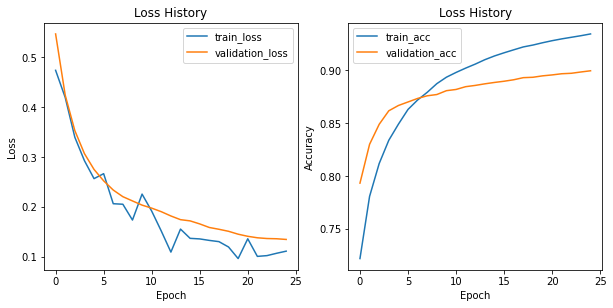

In [12]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.title('Loss History')
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['validation_loss'], label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(222)
plt.title('Loss History')
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='validation_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluation

In [13]:
y_pred = model.predict(test_dataset).argmax(axis=1)

In [14]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93        75
           1       0.97      0.88      0.92        75

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150



<AxesSubplot:title={'center':'Confusion Matrix'}>

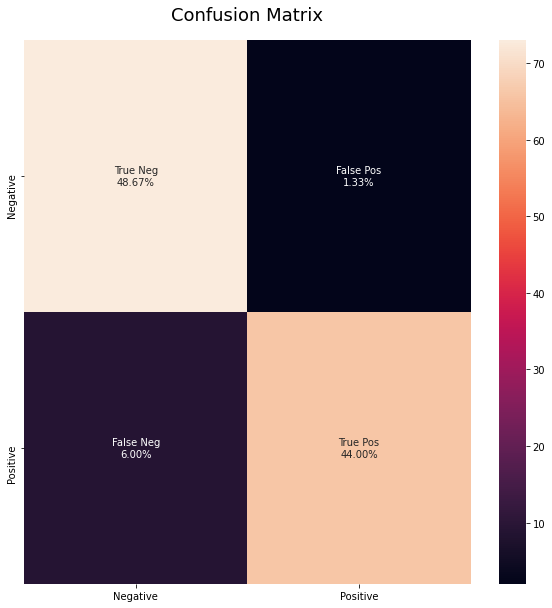

In [15]:
plt.figure(figsize=(10, 10))
conf_mat = confusion_matrix(test_labels, y_pred)
categories = ['Negative', 'Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']

group_percentage = [
    '{0:.2%}'.format(value) for value in conf_mat.ravel() / conf_mat.sum()
]

cm_labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentage)]

cm_labels = np.array(cm_labels).reshape(2, 2)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
sns.heatmap(
    conf_mat, annot=cm_labels, fmt='',
    xticklabels=categories, yticklabels=categories
)

In [16]:
print('Roc: {}\nMCC: {}'.format(
    round(roc_auc_score(test_labels, y_pred, average='macro'), 2), 
    round(matthews_corrcoef(test_labels, y_pred), 2))
)

Roc: 0.93
MCC: 0.86


# Visually Inspect
- Lets run inference and check manually how does our model perform

In [17]:
decoder = {
    0: 'not hot dog',
    1: 'hot dog'
}

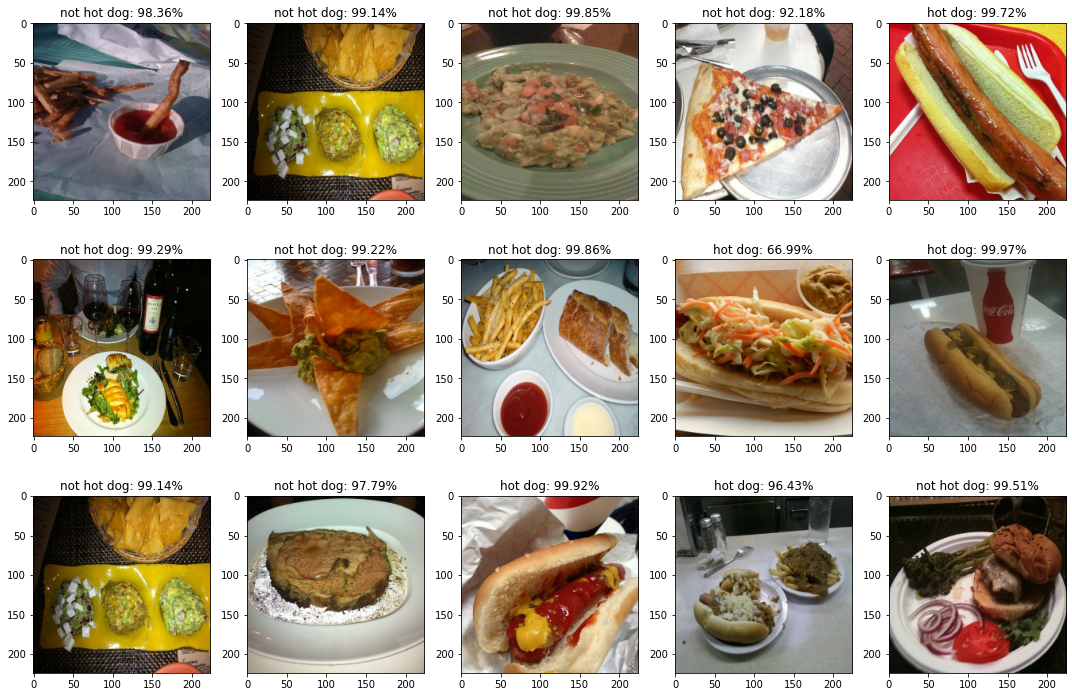

In [18]:
row, column, count = 3, 5, 0

plt.figure(figsize=(15, 10))
for test_image in np.random.choice(test_data, size=15):
    # Read and preproc image
    image = tf.io.decode_jpeg(tf.io.read_file(test_image), channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.
    image = tf.expand_dims(image, axis=0)
    
    # Forward pass and post proc
    pred = model(image) # Similar to how pytorch does it
    pred = tf.squeeze(pred, axis=0)
    pred = pred.numpy()

    count += 1
    plt.subplot(row, column, count)
    plt.title(decoder[pred.argmax()] + ': ' + str(round(pred.max() * 100, 2)) + '%')
    plt.imshow(tf.cast(image[0] * 255, tf.uint8))
    
plt.tight_layout()
plt.show()

# Save model

In [ ]:
tf.saved_model.save(model, 'weights/effnet_hotdog')